# **Imports**

In [1]:
from tensorflow import keras
from keras.layers import Dense,Input, Lambda, Dense, Flatten,Dropout
from keras.models import Sequential, Model
from keras.applications.vgg19 import VGG19, preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

**Downloading the dataset**

In [2]:
!gdown "1Y33uSoZ0NjXtzowBiP5Q0jAp1GkCO6WZ"

Downloading...
From: https://drive.google.com/uc?id=1Y33uSoZ0NjXtzowBiP5Q0jAp1GkCO6WZ
To: /content/BeeImagesDataset.zip
100% 29.4M/29.4M [00:00<00:00, 59.9MB/s]


In [ ]:
!unzip BeeImagesDataset.zip

In [4]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

# **Test Train Validation**

In [5]:
train_path="BeeImagesDataset/train"
test_path="BeeImagesDataset/test"
val_path="BeeImagesDataset/validation"

In [6]:
x_train=[]

for folder in os.listdir(train_path):
    sub_path=train_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_train.append(img_arr)

In [7]:
x_test=[]

for folder in os.listdir(test_path):
    sub_path=test_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_test.append(img_arr)
    

In [8]:
x_val=[]

for folder in os.listdir(val_path):
    sub_path=val_path+"/"+folder
    for img in os.listdir(sub_path):
        image_path=sub_path+"/"+img
        img_arr=cv2.imread(image_path)
        img_arr=cv2.resize(img_arr,(224,224))
        x_val.append(img_arr)
    

In [9]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)

In [10]:
train_x.shape,test_x.shape,val_x.shape

((750, 224, 224, 3), (750, 224, 224, 3), (750, 224, 224, 3))

In [11]:
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)


training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')

test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')


Found 750 images belonging to 5 classes.
Found 750 images belonging to 5 classes.
Found 750 images belonging to 5 classes.


# **Deceises and Class Mapping**

In [13]:
training_set.class_indices

{'BeeViruses': 0,
 'EuropeanFoulbrood': 1,
 'NoDisease': 2,
 'Nosema': 3,
 'VarroaMites': 4}

In [14]:
train_y=training_set.classes

In [15]:
test_y=test_set.classes

In [16]:
val_y=val_set.classes

In [17]:
train_y.shape,test_y.shape,val_y.shape

((750,), (750,), (750,))

# **VGG CNN Model**

In [18]:
# add preprocessing layer to the front of VGG
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

80134624/80134624 [==============================] - 4s 0us/step


In [19]:
for layer in vgg.layers:
    layer.trainable = False

In [20]:
x = Flatten()(vgg.output)

prediction = Dense(5, activation='softmax')(x)

In [21]:
# create a model object
model = Model(inputs=vgg.input, outputs=prediction)

# view the structure of the model
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [22]:
# tell the model what cost and optimization method to use
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

In [23]:
from keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)

# **Fit the model**

In [24]:
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/10
24/24 [==============================] - 20s 398ms/step - loss: 1.5716 - accuracy: 0.4693 - val_loss: 2.4108 - val_accuracy: 0.2520
Epoch 2/10
24/24 [==============================] - 9s 367ms/step - loss: 0.7380 - accuracy: 0.7000 - val_loss: 2.0428 - val_accuracy: 0.3600
Epoch 3/10
24/24 [==============================] - 7s 291ms/step - loss: 0.5759 - accuracy: 0.7813 - val_loss: 2.1104 - val_accuracy: 0.2960
Epoch 4/10
24/24 [==============================] - 7s 293ms/step - loss: 0.4637 - accuracy: 0.8213 - val_loss: 2.1522 - val_accuracy: 0.3907
Epoch 5/10
24/24 [==============================] - 9s 371ms/step - loss: 0.3717 - accuracy: 0.8693 - val_loss: 1.9683 - val_accuracy: 0.4227
Epoch 6/10
24/24 [==============================] - 7s 304ms/step - loss: 0.3225 - accuracy: 0.8907 - val_loss: 1.9390 - val_accuracy: 0.4027
Epoch 7/10
24/24 [==============================] - 9s 374ms/step - loss: 0.2626 - accuracy: 0.9200 - val_loss: 1.9465 - val_accuracy: 0.4160
Epoch

# **Plotting the graphs**

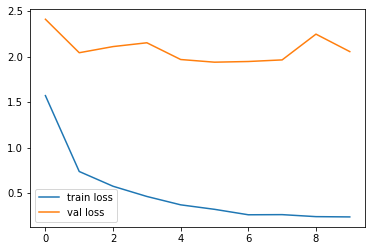

In [25]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('vgg-loss-rps-1.png')
plt.show()

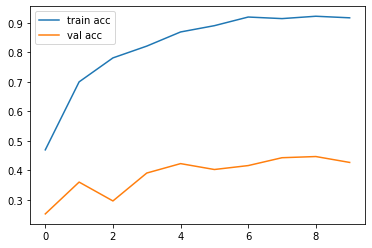

In [26]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('vgg-acc-rps-1.png')
plt.show()

In [27]:
model.evaluate(test_x,test_y,batch_size=32)

24/24 [==============================] - 4s 149ms/step - loss: 0.5875 - accuracy: 0.8027


[0.5875195860862732, 0.8026666641235352]

In [28]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [29]:
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)

24/24 [==============================] - 4s 151ms/step


# **Accuracy Mesurements**

In [30]:
accuracy_score(y_pred,test_y)

0.8026666666666666

In [31]:
print(classification_report(y_pred,test_y))

              precision    recall  f1-score   support

           0       0.85      0.74      0.79       171
           1       0.99      0.71      0.83       210
           2       0.77      0.80      0.79       145
           3       0.96      0.94      0.95       153
           4       0.44      0.93      0.60        71

    accuracy                           0.80       750
   macro avg       0.80      0.82      0.79       750
weighted avg       0.86      0.80      0.81       750



In [32]:
confusion_matrix(y_pred,test_y)

array([[127,   0,   6,   0,  38],
       [ 16, 149,  27,   6,  12],
       [  2,   0, 116,   0,  27],
       [  2,   0,   0, 144,   7],
       [  3,   1,   1,   0,  66]])

#**Prediction**

In [33]:
import keras.utils as image

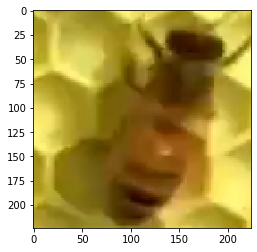

1/1 [==============================] - 0s 21ms/step
NoDisease


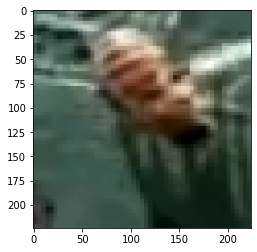

1/1 [==============================] - 0s 22ms/step
VarroaMites


In [35]:
path="test"
for img in os.listdir(path):
    img=image.load_img(path+"/"+img,target_size=(224,224))
    plt.imshow(img)
    plt.show()
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    images=np.vstack([x])
    pred=model.predict(images,batch_size=1) 
    if pred[0][0]>0.5:
        print("BeeViruses")
    elif pred[0][1]>0.5:
        print("EuropeanFoulbrood")
    elif pred[0][2]>0.5:
        print("NoDisease")
    elif pred[0][3]>0.5:
        print("Nosema")
    elif pred[0][4]>0.5:
        print("VarroaMites")
    else:
        print("Unknown")

In [36]:
model.save("vgg-bee-dicease-modal-final.h5")

# **Loading the model**

In [37]:
from tensorflow import keras
from keras.models import load_model
import os
import matplotlib.pyplot as plt
import keras.utils as image
from keras.applications.vgg19 import preprocess_input
import numpy as np
import cv2

In [38]:
model=load_model("vgg-bee-dicease-modal-final.h5")

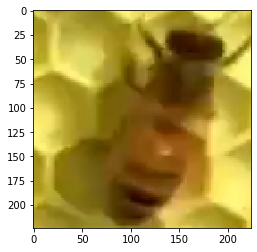

1/1 [==============================] - 0s 34ms/step
NoDisease


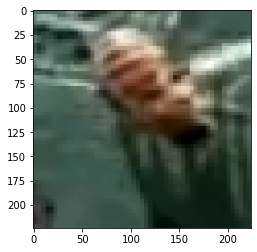

1/1 [==============================] - 0s 32ms/step
VarroaMites


In [40]:
path="test"
i=0

for img in os.listdir(path):
    img=image.load_img(path+"/"+img,target_size=(224,224))
    plt.imshow(img)
    plt.show()
    
    x=image.img_to_array(img)
    x=np.expand_dims(x,axis=0)
    images=np.vstack([x])
    pred=model.predict(images,batch_size=1) 
    if pred[0][0]>0.5:
        print("BeeViruses")
    elif pred[0][1]>0.5:
        print("EuropeanFoulbrood")
    elif pred[0][2]>0.5:
        print("NoDisease")
    elif pred[0][3]>0.5:
        print("Nosema")
    elif pred[0][4]>0.5:
        print("VarroaMites")  